In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

In [2]:
rul = pd.read_csv("data/RUL_FD001.txt", header=None).values.reshape(-1)
df_train = pd.read_csv("data/train_FD001.txt", sep=' ', header=None)
df_train = df_train.drop(df_train.columns[-2:], axis=1)
df_test = pd.read_csv("data/test_FD001.txt", sep=' ', header=None)
df_test = df_test.drop(df_test.columns[-2:], axis=1)

In [3]:
column_selected = df_train[df_train.iloc[:, 0] == 1].std() > 1e-10
column_selected[0:5] = True

In [4]:
df_train = df_train.loc[:, column_selected]
df_test = df_test.loc[:, column_selected]

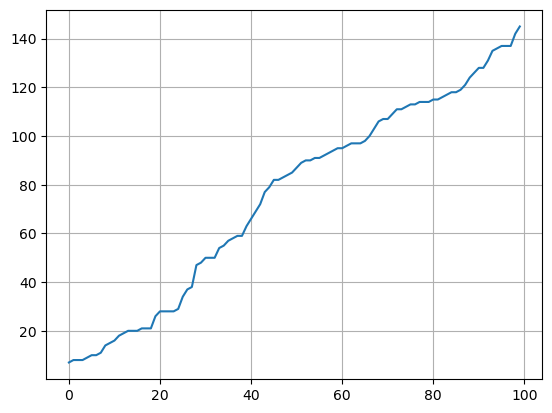

In [5]:
plt.plot(np.sort(rul))
plt.grid()

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_train = scaler.fit_transform(df_train.iloc[:, 5:])
data_test = scaler.fit_transform(df_test.iloc[:, 5:])

In [7]:
window_size = 30
y_cap = 130
train_X = []
train_no = []
train_label = []

for i in range(1, 101):
    data_unit = data_train[df_train.iloc[:, 0] == i]
    train_X_unit = []
    train_no_unit = []

    for j in range(window_size-1):
        X_pad = np.zeros([window_size, data_unit.shape[-1]])
        X_pad[-j-1:, :] = data_unit[:j+1, :]
        train_X_unit.append(X_pad)
        train_no_unit.append(i)

    for j in range(len(data_unit)-window_size+1):
        train_X_unit.append(data_unit[j:j+window_size, :])
        train_no_unit.append(i)

    rul_unit = rul[i-1]
    y_unit = np.arange(rul_unit, 0, -1) - 1
    y_unit = y_unit[:min(rul_unit, len(data_unit))] # RUL of No.39 is larger than duration
    y_unit[y_unit>y_cap] = y_cap

    train_X += train_X_unit[:rul_unit]
    train_no += train_no_unit[:rul_unit]

    train_label += list(y_unit)

    #print((i, len(train_label), len(train_X), rul_unit, len(data_unit)))

train_X = torch.tensor(np.array(train_X), dtype=torch.float32)
train_label = torch.tensor(np.array(train_label), dtype=torch.float32)
train_no = torch.tensor(np.array(train_no), dtype=torch.int32)

In [8]:
test_X = []
test_label = []
test_no = []

for i in range(1, 101):
    data_unit = data_test[df_test.iloc[:, 0] == i]
    test_X_unit = []
    test_no_unit = []

    for j in range(window_size-1):
        X_pad = np.zeros([window_size, data_unit.shape[-1]])
        X_pad[-j-1:, :] = data_unit[:j+1, :]
        test_X_unit.append(X_pad)
        test_no_unit.append(i)

    for j in range(len(data_unit)-window_size+1):
        test_X_unit.append(data_unit[j:j+window_size, :])
        test_no_unit.append(i)

    rul_unit = len(data_unit)
    y_unit = np.arange(rul_unit, 0, -1) - 1
    y_unit[y_unit>y_cap] = y_cap

    test_X += test_X_unit
    test_no += test_no_unit
    test_label += list(y_unit)

test_X = torch.tensor(np.array(test_X), dtype=torch.float32)
test_label = torch.tensor(np.array(test_label), dtype=torch.float32)
test_no = torch.tensor(np.array(test_no), dtype=torch.int32)

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.Tanh()
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        return x.reshape(-1)

In [10]:
input_dim = 30 * 14
hidden_dim = 128
output_dim = 1
model = MLP(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
batch_size = 64

train_dataset = TensorDataset(train_X, train_label)
test_dataset = TensorDataset(test_X, test_label)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
num_epochs = 500
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    for i, (inputs, labels) in enumerate(train_loader):
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0 and (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("训练结束")

  2%|▏         | 10/500 [00:02<01:40,  4.86it/s]

Epoch [10/500], Step [100/118], Loss: 951.3152


  4%|▍         | 20/500 [00:04<01:37,  4.92it/s]

Epoch [20/500], Step [100/118], Loss: 754.5754


  6%|▌         | 30/500 [00:06<01:34,  4.99it/s]

Epoch [30/500], Step [100/118], Loss: 641.2019


  8%|▊         | 40/500 [00:08<01:32,  4.98it/s]

Epoch [40/500], Step [100/118], Loss: 732.7057


 10%|█         | 50/500 [00:10<01:29,  5.05it/s]

Epoch [50/500], Step [100/118], Loss: 489.0037


 12%|█▏        | 60/500 [00:12<01:25,  5.12it/s]

Epoch [60/500], Step [100/118], Loss: 399.1671


 14%|█▍        | 70/500 [00:14<01:24,  5.11it/s]

Epoch [70/500], Step [100/118], Loss: 538.2877


 16%|█▌        | 80/500 [00:16<01:23,  5.04it/s]

Epoch [80/500], Step [100/118], Loss: 359.0108


 18%|█▊        | 91/500 [00:18<01:19,  5.16it/s]

Epoch [90/500], Step [100/118], Loss: 456.4523


 20%|██        | 100/500 [00:20<01:17,  5.15it/s]

Epoch [100/500], Step [100/118], Loss: 252.3804


 22%|██▏       | 110/500 [00:21<01:16,  5.09it/s]

Epoch [110/500], Step [100/118], Loss: 231.6853


 24%|██▍       | 120/500 [00:23<01:13,  5.19it/s]

Epoch [120/500], Step [100/118], Loss: 244.0134


 26%|██▌       | 130/500 [00:25<01:12,  5.10it/s]

Epoch [130/500], Step [100/118], Loss: 191.9325


 28%|██▊       | 140/500 [00:27<01:14,  4.86it/s]

Epoch [140/500], Step [100/118], Loss: 247.9699


 30%|███       | 150/500 [00:29<01:10,  4.98it/s]

Epoch [150/500], Step [100/118], Loss: 167.7153


 32%|███▏      | 160/500 [00:31<01:06,  5.12it/s]

Epoch [160/500], Step [100/118], Loss: 120.8838


 34%|███▍      | 170/500 [00:33<01:06,  4.96it/s]

Epoch [170/500], Step [100/118], Loss: 123.4456


 36%|███▌      | 180/500 [00:35<01:04,  4.98it/s]

Epoch [180/500], Step [100/118], Loss: 121.4086


 38%|███▊      | 190/500 [00:37<01:03,  4.90it/s]

Epoch [190/500], Step [100/118], Loss: 156.3497


 40%|████      | 200/500 [00:40<01:03,  4.74it/s]

Epoch [200/500], Step [100/118], Loss: 36.3326


 42%|████▏     | 210/500 [00:42<00:57,  5.08it/s]

Epoch [210/500], Step [100/118], Loss: 102.9190


 44%|████▍     | 220/500 [00:44<00:55,  5.02it/s]

Epoch [220/500], Step [100/118], Loss: 58.5439


 46%|████▌     | 230/500 [00:46<00:53,  5.08it/s]

Epoch [230/500], Step [100/118], Loss: 25.7463


 48%|████▊     | 240/500 [00:48<00:51,  5.00it/s]

Epoch [240/500], Step [100/118], Loss: 56.4085


 50%|█████     | 250/500 [00:50<00:49,  5.06it/s]

Epoch [250/500], Step [100/118], Loss: 35.8026


 52%|█████▏    | 260/500 [00:52<00:47,  5.05it/s]

Epoch [260/500], Step [100/118], Loss: 30.7905


 54%|█████▍    | 270/500 [00:54<00:46,  4.98it/s]

Epoch [270/500], Step [100/118], Loss: 13.1345


 56%|█████▌    | 280/500 [00:55<00:43,  5.10it/s]

Epoch [280/500], Step [100/118], Loss: 26.2979


 58%|█████▊    | 290/500 [00:57<00:41,  5.12it/s]

Epoch [290/500], Step [100/118], Loss: 17.6341


 60%|██████    | 300/500 [00:59<00:39,  5.12it/s]

Epoch [300/500], Step [100/118], Loss: 31.5072


 62%|██████▏   | 310/500 [01:01<00:37,  5.08it/s]

Epoch [310/500], Step [100/118], Loss: 33.8510


 64%|██████▍   | 320/500 [01:03<00:35,  5.00it/s]

Epoch [320/500], Step [100/118], Loss: 16.1460


 66%|██████▌   | 330/500 [01:05<00:33,  5.04it/s]

Epoch [330/500], Step [100/118], Loss: 18.5548


 68%|██████▊   | 340/500 [01:07<00:31,  5.05it/s]

Epoch [340/500], Step [100/118], Loss: 50.6231


 70%|███████   | 350/500 [01:09<00:30,  4.89it/s]

Epoch [350/500], Step [100/118], Loss: 17.3755


 72%|███████▏  | 360/500 [01:11<00:28,  4.88it/s]

Epoch [360/500], Step [100/118], Loss: 12.2650


 74%|███████▍  | 370/500 [01:13<00:25,  5.12it/s]

Epoch [370/500], Step [100/118], Loss: 19.4919


 76%|███████▌  | 380/500 [01:15<00:23,  5.10it/s]

Epoch [380/500], Step [100/118], Loss: 21.4566


 78%|███████▊  | 390/500 [01:17<00:21,  5.14it/s]

Epoch [390/500], Step [100/118], Loss: 8.1326


 80%|████████  | 400/500 [01:19<00:19,  5.13it/s]

Epoch [400/500], Step [100/118], Loss: 12.8663


 82%|████████▏ | 410/500 [01:21<00:17,  5.17it/s]

Epoch [410/500], Step [100/118], Loss: 11.1549


 84%|████████▍ | 420/500 [01:23<00:15,  5.10it/s]

Epoch [420/500], Step [100/118], Loss: 13.7608


 86%|████████▌ | 430/500 [01:25<00:14,  4.73it/s]

Epoch [430/500], Step [100/118], Loss: 21.8286


 88%|████████▊ | 440/500 [01:27<00:12,  4.77it/s]

Epoch [440/500], Step [100/118], Loss: 10.2698


 90%|█████████ | 450/500 [01:29<00:10,  4.83it/s]

Epoch [450/500], Step [100/118], Loss: 5.8147


 92%|█████████▏| 460/500 [01:31<00:08,  4.92it/s]

Epoch [460/500], Step [100/118], Loss: 10.7976


 94%|█████████▍| 470/500 [01:33<00:06,  4.89it/s]

Epoch [470/500], Step [100/118], Loss: 5.0583


 96%|█████████▌| 480/500 [01:36<00:04,  4.76it/s]

Epoch [480/500], Step [100/118], Loss: 10.1673


 98%|█████████▊| 490/500 [01:38<00:02,  4.87it/s]

Epoch [490/500], Step [100/118], Loss: 8.7005


100%|██████████| 500/500 [01:40<00:00,  4.99it/s]

Epoch [500/500], Step [100/118], Loss: 48.6291
训练结束


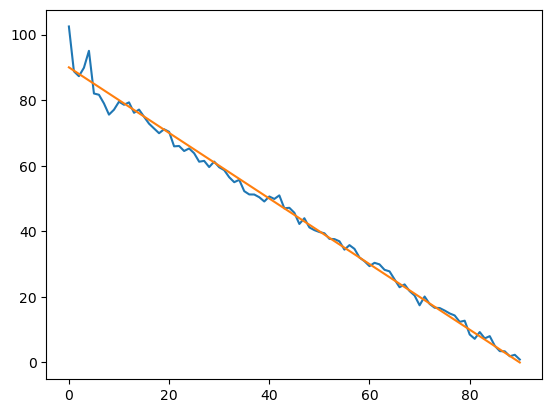

In [16]:
model.eval()
pred = model(train_X[train_no==5]).detach().numpy()
plt.plot(pred)
plt.plot(train_label[train_no==5])

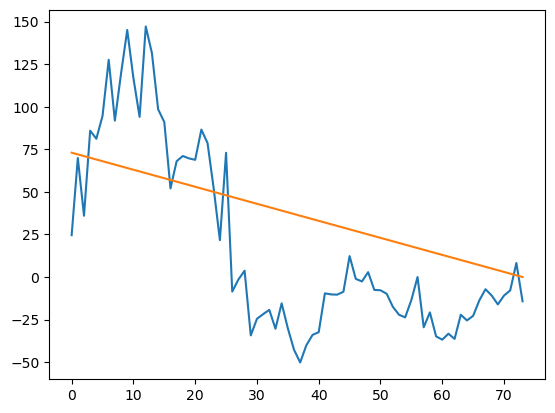

In [17]:
model.eval()
pred = model(test_X[test_no==50]).detach().numpy()
plt.plot(pred)
plt.plot(test_label[test_no==50])